# Homework 2
## Eric Schulman

In [7]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [105]:
wage1 = pd.read_stata('Homework/WAGE1.DTA')

We use the Nadarya Watson Kernel estimator with the uniform kernel and Silverman bandwidth

$\hat{m}(z) = \dfrac{\hat{\phi}(z)}{\hat{f}_z} = \dfrac{\sum_i Y_i K(\frac{z-Z_i}{h})}{K(\frac{z-Z_i}{h})}$

Since, gender is discrete we can simply use an indicator function in its place.

In [106]:
labels = ['educ','exper','female']
print labels[2:]+labels[:2]

['female', 'educ', 'exper']


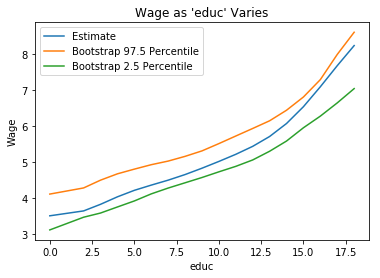

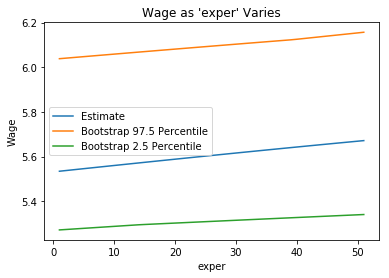

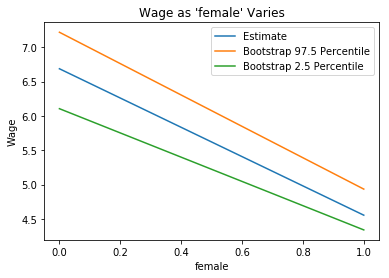

In [149]:
labels = ['educ','exper','female']

sigma = wage1.var()[['educ','exper','female']]
nobs = wage1.shape[0]
bands = 1.06*sigma*nobs**(-(1./5.))

model = sm.nonparametric.KernelReg(wage1['wage'],wage1[['educ','exper','female']], ['c','c','u'], 
                                   bw=bands ,reg_type='lc')

mu = wage1.mean()[['educ','exper','female']]


#boot strap 100 samples of 200 observations

for x  in labels:
    
    #pull data from array
    data = np.array(wage1[x].copy().unique())
    data.sort()
    
    const = np.repeat(mu,len(data))
    const[x] = data
    
    const = np.array(const).reshape(3,len(data))
    y = model.fit(const)
    plt.plot(data, y[0], label = 'Estimate')
    
    
    #run bootstrap
    bootstrap = []
    
    for i in range(100):
        #draw subsample
        subn = 200
        sample = np.random.choice(np.arange(0,nobs), subn , replace=False)
        sample = wage1.iloc[sample]
        
        #compute bands
        sub_sigma = sample.var()[['educ','exper','female']]
        sub_bands = 1.06*sub_sigma*subn**(-(1./5.))
    
        #re run the model
        boot_model = sm.nonparametric.KernelReg(sample['wage'],sample[['educ','exper','female']],
                                               ['c','c','u'], bw=sub_bands ,reg_type='lc')
        boot_y = boot_model.fit(const)[0]
        bootstrap.append(boot_y)
    
    bootstrap = np.array(bootstrap)

    #plot upper bound
    bootstrap_l = np.percentile(bootstrap , 97.5,axis=0)
    plt.plot(data, bootstrap_l, label='Bootstrap 97.5 Percentile')
    
    #plot lower bound
    bootstrap_u = np.percentile(bootstrap , 2.5,axis=0)
    plt.plot(data, bootstrap_u, label='Bootstrap 2.5 Percentile')
    
    plt.ylabel('Wage')
    plt.xlabel(x)
    plt.title("Wage as '%s' Varies"%x)
    plt.legend()
    plt.show()
    